In [4]:
import pandas as pd
import os, sys
import ujson, re
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from src.DataReader import DataReader
from src.constants import SPLIT_TIME, STORE_LOCATION, DATA_ROOT, POSTS_FILE, VOTES_FILE
from operator import itemgetter

/Users/prmathur/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Couldn't import dot_parser, loading of dot files will not be possible.


In [5]:
%matplotlib inline

In [6]:
emb_root = '/Users/prmathur/Documents/Pers/MMDS/Course/CS224W/Project/snap-master/examples/node2vec/emb/'

In [7]:
data_directory = DATA_ROOT

In [8]:
train_df = pd.read_csv(os.path.join(STORE_LOCATION, 'train.csv'))

In [9]:
test_df = pd.read_csv(os.path.join(STORE_LOCATION, 'test.csv'))

In [10]:
post_reader = DataReader(os.path.join(data_directory, POSTS_FILE), True)
post_reader.read_data()

Reading file...
Converting...
Progress | ██████████ | 100% || Estimated time remaining: 0.0 seconds
Conversion complete...
Forming data frame...


In [11]:
pdf = post_reader._df

q_tags_df = pdf[pdf.PostTypeId==1][['Id', 'Tags']]

train_df = train_df.merge(q_tags_df, how='left', left_on='QuestionId', right_on='Id', suffixes=('_tr', '_qt'))

test_df = test_df.merge(q_tags_df, how='left', left_on='QuestionId', right_on='Id', suffixes=('_tr', '_qt'))

In [12]:
train_df[['QuestionId', 'AcceptedAnswerUserId', 'UsersSorted', 'Tags']].head()

,QuestionId,AcceptedAnswerUserId,UsersSorted,Tags
0,5.0,45.0,"[45.0, 1102.0, 48.0, 226.0, 242.0]","[elementary-number-theory, proof-writing, radi..."
1,1.0,8.0,"[8.0, 49.0, 25.0, 35.0, 39.0]","[elementary-set-theory, intuition, faq]"
2,8.0,38.0,"[38.0, 173.0, 334.0, 53.0, 55.0]","[linear-algebra, combinatorics, generating-fun..."
3,2.0,34.0,"[34.0, 56.0, 35.0, 190287.0, 72.0]","[calculus, limits, definition]"
4,20.0,38.0,"[38.0, 72.0, 232.0, 51.0, 210.0]","[terminology, definition, number-systems]"


In [13]:
indx2tag_dict = {}
tag2index_dict = {}
with open(os.path.join(STORE_LOCATION, 'graphs/user-tag_keys.txt')) as tg_fl:
    for row in tg_fl:
        k, v = row.strip().split(',')
        indx2tag_dict[float(v.strip())] = k
        tag2index_dict[k] = float(v.strip())

In [21]:
val_df = train_df.iloc[11000:]

train_df = train_df.iloc[:11000]

In [25]:
# print model.syn0[model.vocab['10000958'].index].shape
# print model.index2word[169]

In [26]:
def get_user_vals(users):
    return re.findall(r'[{]*(\d+).0', users)

In [27]:
def get_rep(row, model):
    tags = row.Tags
    tag_id = [str(int(tag2index_dict[t])) for t in tags]
    w2v_idx = [model.vocab[t].index for t in tag_id]
    t_vectors = model.syn0[w2v_idx]
    q = t_vectors.mean(axis=0)
    
    accepted_user = str(int(row.AcceptedAnswerUserId))
    user_vec = {}

    output = None
    
    users = get_user_vals(row.UsersSorted)
    for u in users:
        user = str(int(u))
        op_row = None
        
        if user in model.vocab:
            user_w2v_idx = model.vocab[user].index
            user_vector = model.syn0[user_w2v_idx]
        else:
            user_vector = np.zeros(128)
        
        if user == accepted_user:
            op_row = np.hstack((q, user_vector, 1))
        else:
            op_row = np.hstack((q, user_vector, 0))
            
        if output is None:
            output = op_row
        else:
            output = np.vstack((output, op_row))

    return output

In [28]:
def get_accuracy(preds, Y):
    pr, tr = [], []
    for i in range(0, preds.shape[0] ,5):
        pr.append(np.argmax(preds[i:i+5]))
        tr.append(np.argmax(Y[i:i+5]))

    pr = np.array(pr)
    tr = np.array(tr)
    
    return (pr==tr).sum()* 1. / pr.shape[0] 

In [32]:
def get_mrr(preds, Y):

    ranks = []
    for i in range(0, preds.shape[0] ,5):
        max_idx = np.argmax(Y[i:i+5])
        srt = np.argsort(preds[i:i+5],)[::-1]
        rank = np.where(srt==max_idx)[0][0] + 1

        ranks.append(rank)

    return np.mean(1. / np.array(ranks))

In [29]:
# temp = get_rep(train_df.ix[0], model)

In [30]:
ut_files = [f for f in os.listdir(emb_root) if 'ut' in f]

In [31]:
uu_files = [f for f in os.listdir(emb_root) if 'uu' in f]

In [33]:
for emb_file in ut_files:
    model = Word2Vec.load_word2vec_format(os.path.join(emb_root, emb_file), binary=False)
    print 'Loaded {}\n'.format(emb_file)
    
    train_ds, val_ds = [], []
    for indx, row in train_df.iterrows():
        temp_set = get_rep(row, model)
        train_ds.append(temp_set)
        
        if indx % 1000 == 0:
            sys.stdout.write('.')
            sys.stdout.flush()

    train_ds = np.vstack(train_ds)
    
    for indx, row in val_df.iterrows():
        temp_set = get_rep(row, model)
        val_ds.append(temp_set)
        
        if indx % 1000 == 0:
            sys.stdout.write('.')
            sys.stdout.flush()

    val_ds = np.vstack(val_ds)
    
    print '\nBegin train'
    clf = LogisticRegression(n_jobs=-1)
    clf.fit(train_ds[:, :256], train_ds[:, 256])
    preds = clf.predict_proba(val_ds[:, :256])[:, 1]
    score = get_accuracy(preds, val_ds[:, 256])
    mrr = get_mrr(preds, val_ds[:, 256])

    p, q = emb_file.replace('.emb', '').replace('ut_', '').split('-')
    print '{0}; {1} : acc - {2}; mrr - {3}'.format(p, q, score, mrr)

Loaded ut_p0.25-q0.25.emb

................
Begin train
p0.25; q0.25 : acc - 0.374687239366; mrr - 0.617417292188
Loaded ut_p0.25-q0.50.emb

................
Begin train
p0.25; q0.50 : acc - 0.374478732277; mrr - 0.616972477064
Loaded ut_p0.25-q1.emb

................
Begin train
p0.25; q1 : acc - 0.388448707256; mrr - 0.626661106478
Loaded ut_p0.25-q2.emb

................
Begin train
p0.25; q2 : acc - 0.379482902419; mrr - 0.619596191271
Loaded ut_p0.25-q4.emb

................
Begin train
p0.25; q4 : acc - 0.383236030025; mrr - 0.62228940784
Loaded ut_p0.50-q0.25.emb

................
Begin train
p0.50; q0.25 : acc - 0.371351125938; mrr - 0.614724075619
Loaded ut_p0.50-q0.50.emb

................
Begin train
p0.50; q0.50 : acc - 0.380108423686; mrr - 0.621232971921
Loaded ut_p0.50-q1.emb

................
Begin train
p0.50; q1 : acc - 0.376772310259; mrr - 0.617493744787
Loaded ut_p0.50-q2.emb

................
Begin train
p0.50; q2 : acc - 0.375312760634; mrr - 0.619363358354
Loade

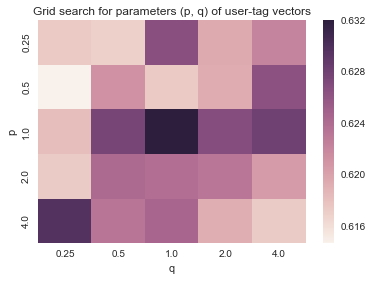

In [40]:
perf_df = pd.DataFrame([(0.25, 0.25, 0.374687239366, 0.617417292188), (0.25, 0.50, 0.374478732277, 0.616972477064), 
                        (0.25, 1, 0.388448707256, 0.626661106478), (0.25, 2, 0.379482902419, 0.619596191271), 
                        (0.25, 4, 0.383236030025, 0.62228940784), (0.50, 0.25, 0.371351125938, 0.614724075619), 
                        (0.50, 0.50, 0.380108423686, 0.621232971921), (0.50, 1, 0.376772310259, 0.617493744787), 
                        (0.50, 2, 0.375312760634, 0.619363358354), (0.50, 4, 0.388657214345, 0.626511676397), 
                        (1, 0.25, 0.377189324437, 0.6182235196), (1, 0.50, 0.390742285238, 0.62761676397), 
                        (1, 1, 0.39845704754, 0.632082290798), (1, 2, 0.389491242702, 0.626890464276), 
                        (1, 4, 0.392410341952, 0.628120656102), (2, 0.25, 0.37364470392, 0.617347789825), 
                        (2, 0.50, 0.389908256881, 0.624245899361), (2, 1, 0.388657214345, 0.623846260773), 
                        (2, 2, 0.385946622185, 0.623210314151), (2, 4, 0.379691409508, 0.620496246872), 
                        (4, 0.25, 0.395120934112, 0.629771337225), (4, 0.50, 0.38448707256, 0.623387545177), 
                        (4, 1, 0.38740617181, 0.624596886294), (4, 2, 0.379899916597, 0.619283430637), 
                        (4, 4, 0.374478732277, 0.617358215179)])

perf_df.columns = ['p', 'q', 'Accuracy', 'Mrr']
ax = sns.heatmap(perf_df.pivot('p', 'q', 'Mrr'))
plt.title('Grid search for parameters (p, q) of user-tag vectors')

In [41]:
ut_model = Word2Vec.load_word2vec_format(os.path.join(emb_root, 'ut_p1-q1.emb'), binary=False)

In [42]:
def get_rep_uu(row, ut_model, uu_model):
    tags = row.Tags
    tag_id = [str(int(tag2index_dict[t])) for t in tags if t in tag2index_dict]
    w2v_idx = [ut_model.vocab[t].index for t in tag_id if t in ut_model.vocab]
    t_vectors = ut_model.syn0[w2v_idx]
    q = t_vectors.mean(axis=0)
    
    accepted_user = str(int(row.AcceptedAnswerUserId))
    user_vec = {}

    output = None
    
    users = get_user_vals(row.UsersSorted)
    for u in users:
        user = str(int(u))
        op_row = None
        
        if user in ut_model.vocab:
            user_w2v_idx = ut_model.vocab[user].index
            user_vector = ut_model.syn0[user_w2v_idx]
        else:
#             print user
            user_vector = np.zeros(128)
            
        if user in uu_model.vocab:
            user_uu_w2v_idx = uu_model.vocab[user].index
            user_uu_vector = uu_model.syn0[user_uu_w2v_idx]
        else:
#             print user, users
            user_uu_vector = np.zeros(128)
        
        if user == accepted_user:
            op_row = np.hstack((q, user_vector, user_uu_vector, 1))
        else:
            op_row = np.hstack((q, user_vector, user_uu_vector, 0))
            
        if output is None:
            output = op_row
        else:
            output = np.vstack((output, op_row))

    return output

In [43]:
# get_rep_uu(train_df.ix[0], ut_model, uu_model).shape

In [44]:
# for indx, row in train_df.iterrows():
#     temp_set = get_rep_uu(train_df.ix[0], ut_model, uu_model)

In [45]:
for emb_file in uu_files:
#     model = Word2Vec.load_word2vec_format(os.path.join(emb_root, emb_file), binary=False)
    uu_model = Word2Vec.load_word2vec_format(os.path.join(emb_root, emb_file), binary=False)
    print 'Loaded {}\n'.format(emb_file)
    
    train_ds, val_ds = [], []
    for indx, row in train_df.iterrows():
        temp_set = get_rep_uu(row, ut_model, uu_model)
        train_ds.append(temp_set)
        
        if indx % 1000 == 0:
            sys.stdout.write('.')
            sys.stdout.flush()

    train_ds = np.vstack(train_ds)
    
    for indx, row in val_df.iterrows():
        temp_set = get_rep_uu(row, ut_model, uu_model)
        val_ds.append(temp_set)
        
        if indx % 1000 == 0:
            sys.stdout.write('.')
            sys.stdout.flush()

    val_ds = np.vstack(val_ds)
    
    print '\nBegin train'
    clf = LogisticRegression(n_jobs=-1)
    clf.fit(train_ds[:, :384], train_ds[:, 384])
    preds = clf.predict_proba(val_ds[:, :384])[:, 1]
    score = get_accuracy(preds, val_ds[:, 384])
    mrr = get_mrr(preds, val_ds[:, 384])

    p, q = emb_file.replace('.emb', '').replace('ut_', '').split('-')
    print '{0}; {1} : acc - {2}; mrr - {3}'.format(p, q, score, mrr)

Loaded uu_p0.25-q0.25.emb

................
Begin train
uu_p0.25; q0.25 : acc - 0.395954962469; mrr - 0.63320822908
Loaded uu_p0.25-q0.50.emb

................
Begin train
uu_p0.25; q0.50 : acc - 0.400542118432; mrr - 0.63320822908
Loaded uu_p0.25-q1.emb

................
Begin train
uu_p0.25; q1 : acc - 0.394495412844; mrr - 0.629660133445
Loaded uu_p0.25-q2.emb

................
Begin train
uu_p0.25; q2 : acc - 0.386989157631; mrr - 0.6260911871
Loaded uu_p0.25-q4.emb

................
Begin train
uu_p0.25; q4 : acc - 0.390742285238; mrr - 0.629510703364
Loaded uu_p0.50-q0.25.emb

................
Begin train
uu_p0.50; q0.25 : acc - 0.39553794829; mrr - 0.630643591882
Loaded uu_p0.50-q0.50.emb

................
Begin train
uu_p0.50; q0.50 : acc - 0.393452877398; mrr - 0.629138865721
Loaded uu_p0.50-q1.emb

................
Begin train
uu_p0.50; q1 : acc - 0.395329441201; mrr - 0.630925076453
Loaded uu_p0.50-q2.emb

................
Begin train
uu_p0.50; q2 : acc - 0.397206005004; mrr

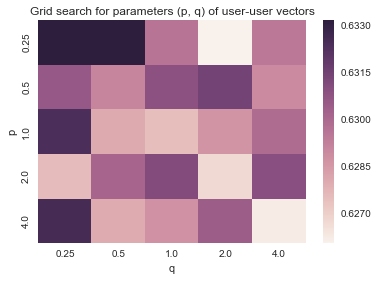

In [46]:
perf_df = pd.DataFrame([(0.25, 0.25, 0.395954962469, 0.63320822908), (0.25, 0.50, 0.400542118432, 0.63320822908), 
                        (0.25, 1, 0.394495412844, 0.629660133445), (0.25, 2, 0.386989157631, 0.6260911871), 
                        (0.25, 4, 0.390742285238, 0.629510703364), (0.50, 0.25, 0.39553794829, 0.630643591882), 
                        (0.50, 0.50, 0.393452877398, 0.629138865721), (0.50, 1, 0.395329441201, 0.630925076453), 
                        (0.50, 2, 0.397206005004, 0.631508896302), (0.50, 4, 0.393452877398, 0.628979010286), 
                        (1, 0.25, 0.397206005004, 0.63245412844), (1, 0.50, 0.391159299416, 0.628037253267), 
                        (1, 1, 0.389491242702, 0.627519460662), (1, 2, 0.393452877398, 0.628676675007), 
                        (1, 4, 0.395954962469, 0.629952043369), (2, 0.25, 0.389699749791, 0.627575062552), 
                        (2, 0.50, 0.394286905755, 0.630202251877), (2, 1, 0.396163469558, 0.631157909369), 
                        (2, 2, 0.38740617181, 0.626761884904), (2, 4, 0.396163469558, 0.630970252989), 
                        (4, 0.25, 0.397623019183, 0.632593133167), (4, 0.50, 0.391159299416, 0.628023352794), 
                        (4, 1, 0.393869891576, 0.628753127606), (4, 2, 0.396163469558, 0.630483736447), 
                        (4, 4, 0.390742285238, 0.626268418126)])

perf_df.columns = ['p', 'q', 'Accuracy', 'Mrr']
ax = sns.heatmap(perf_df.pivot('p', 'q', 'Mrr'))
plt.title('Grid search for parameters (p, q) of user-user vectors')

## Final perf

In [47]:
ut_model = Word2Vec.load_word2vec_format(os.path.join(emb_root, 'ut_p1-q1.emb'), binary=False)

uu_model = Word2Vec.load_word2vec_format(os.path.join(emb_root, 'uu_p0.25-q0.25.emb'), binary=False)

In [48]:
train_ds, val_ds = [], []
for indx, row in train_df.iterrows():
    temp_set = get_rep_uu(row, ut_model, uu_model)
    train_ds.append(temp_set)

    if indx % 1000 == 0:
        sys.stdout.write('.')
        sys.stdout.flush()

train_ds = np.vstack(train_ds)

for indx, row in val_df.iterrows():
    temp_set = get_rep_uu(row, ut_model, uu_model)
    val_ds.append(temp_set)

    if indx % 1000 == 0:
        sys.stdout.write('.')
        sys.stdout.flush()

val_ds = np.vstack(val_ds)

................

In [52]:
clf = LogisticRegression(n_jobs=-1)
clf.fit(train_ds[:, :384], train_ds[:, 384])
preds = clf.predict_proba(val_ds[:, :384])[:, 1]
print get_accuracy(preds, val_ds[:, 384])
print get_mrr(preds, val_ds[:, 384])

0.395954962469
0.63320822908


In [53]:
preds = clf.predict_proba(train_ds[:, :384])[:, 1]
score = get_accuracy(preds, train_ds[:, 384])
mrr = get_mrr(preds, train_ds[:, 384])
print 'Train scores'
print score, mrr

Train scores
0.429818181818 0.653672727273


In [54]:
test_ds = []
for indx, row in test_df.iterrows():
    temp_set = get_rep_uu(row, ut_model, uu_model)
    test_ds.append(temp_set)

    if indx % 1000 == 0:
        sys.stdout.write('.')
        sys.stdout.flush()

test_ds = np.vstack(test_ds)

test_ds.shape

preds = clf.predict_proba(test_ds[:, :384])[:, 1]
print get_accuracy(preds, test_ds[:, 384])
print get_mrr(preds, test_ds[:, 384])

.....0.445730824891
0.672925711529
